In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt

## Math

- s[t] = W.a[t-1] + U.x[t] + b
- a[t] = tahn(s[t])
- yhat = V.a[t] + c
- loss = -y.log(yhat)

## Parameters Update

- U: input parameter
- W: hidden state parameter
- b: input bias
- s[t]: input weighted sum
- a[t]: activation / current hidden state
- V: output parameter
- c: output bias
- yhat: prediction (output weighted sum)

## Gradients / Derivatives: Output Layer

### Derivative of the loss with respect to the prediction

**1. MSE Loss:**
For a regression problem where \(y\) is a scalar value, the MSE loss \(L\) is:
$$L = \frac{1}{n} \sum_{i} (y_i - \hat{y}_i)^2$$

**2. Derivative of Loss with Respect to Output ($$\frac{\partial L}{\partial o_i}$$):**

We want to find how the loss changes with respect to a change in a single element \(o_i\) of the output \(o\). We can use the chain rule:

$$\frac{\partial L}{\partial o_i} = \frac{2}{n} (y_i - \hat{y}_i)$$

### Derivative of the loss with respect to c (output bias)

d(V.a[t] + c)/dc = 1 because V.a[t] is treated as constant, so the derivative of it is 0, and derivative of c is 1.

- do[t]/dc = d(V.a[t] + c)/dc = 1
- dLoss/dc = dLoss/do[t] . do[t]/dc
- dLoss/dc = (y - yhat) . 1 = y - yhat

### Derivative of the loss with respect to V (output weight)

- do[t]/dV = d(V.a[t] + c)/dV = a[t]
- dLoss/dV = dLoss/do[t] . do[t]/dV
- dLoss/dV = (y - yhat) . a[t]

## Gradients / Derivatives: Hidden Layer

### Derivative of the loss with respect to current activation a[t]

The gradient of the current activation w.r.t current output

- do[t]/da[t] = d(V.a[t] + c)/dV = V
- dL[t]/da[t] = dL[t]/do[t] . do[t]/da[t] = (y - yhat) . V

The gradient of current activation w.r.t next time step’s loss

- ds[t+1]/da[t] = d(W.a[t] + U.X[t+1] + b)/da[t] = W
- dL[t+1]/da[t] = dL[t]/ds[t+1] . ds[t+1]/da[t] = dL[t+1]/ds[t+1] . W

The gradient of loss w.r.t current activation a[t]

- dL[t]/da[t] = (yhat - y) . V + dL[t+1]/ds[t+1] . W

### Derivative of the loss with respect to weighted sum of the current time step

- d(tanh(s[t]))/ds[t] = 1 - tanh(s[t])^2
- dL[t]/ds[t] = dL[t]/da[t] . da[t]/ds[t] = dL[t]/da[t] . d(tanh(s[t]))/ds[t]
- dL[t]/ds[t] = dL[t]/da[t] . d(tanh(s[t]))/ds[t] = dL[t]/da[t] . [1 - tanh(s[t])^2]

### Derivative of the loss with respect to W

- dL[t]/dW = dL[t]/da[t] . da[t]/ds[t] . ds[t]/dW
- dL[t]/dW = dL[t]/ds[t] . ds[t]/dW
- ds[t]/dW = d(W.a[t-1] + U.X[t] + b)/dW = a[t-1]
- dL[t]/dW = dL[t]/ds[t] . a[t-1]

### Derivative of the loss with respect to b

- dL[t]/db = dL[t]/da[t] . da[t]/ds[t] . ds[t]/db
- dL[t]/db = dL[t]/ds[t] . ds[t]/db
- ds[t]/db = d(W.a[t-1] + U.X[t] + b)/db = 1
- dL[t]/db = dL[t]/ds[t]

## Gradients / Derivatives: Input Layer

### Derivative of the loss with respect to U

- dL[t]/dU = dL[t]/da[t] . da[t]/ds[t] . ds[t]/dU
- dL[t]/dU = dL[t]/ds[t] . ds[t]/dU
- ds[t]/dU = d(W.a[t-1] + U.X[t] + b)/dU = x[t]
- dL[t]/dU = dL[t]/ds[t] . x[t]

In [2]:
def xavier_uniform(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_out, fan_in))

## Input Layer

In [3]:
class InputLayer:
    def __init__(self, input_features_size, hidden_size):
        '''
        input_features_size: 1
        hidden_size: 32
        U shape: (32,1)
        '''
        self.U = xavier_uniform(input_features_size, hidden_size)
        self.U_gradient = np.zeros_like(self.U)
        self.input_sequence = None

    def weighted_sum(self, time_step):
        '''
        U shape: (32,1)
        get_input shape: (1,1)
        Result shape: (32,1)
        '''
        return self.U @ self.get_input(time_step)

    def compute_gradients(self, time_step, weighted_sum_gradient):
        '''
        - dL[t]/dU = dL[t]/ds[t] . x[t]
        - weighted sum gradient shape: (32,1)
        - input shape: (1,1)
        - U gradient shape: (32,1) @ (1,1) = (32,1)
        '''
        self.U_gradient += (weighted_sum_gradient @ self.get_input(time_step))

    def update_parameters(self, lr):
        self.U -= self.U_gradient * lr

    def get_input(self, time_step):
        '''
        1. self.input[time_step]
           If self.input_sequence is (5, 1), then self.input_sequence[0] will be `np.array([1])`.
           The shape of `np.array([1])` is (1,) -- a 1-dimensional array.
        
        2. .reshape(-1, 1)
           `reshape(-1, 1)` means:
           - The `-1` tells NumPy to automatically calculate the size of that dimension.
           - The `1` means the second dimension should have a size of 1.
           
           So, `np.array([1]).reshape(-1, 1)` takes a (1,) array and reshapes it to (1, 1).
           If it were a (3,) array like `np.array([1, 2, 3])`, `reshape(-1, 1)` would make it (3, 1).
        '''
        return self.input_sequence[time_step].reshape(-1, 1)

    def set_input(self, input_sequence):
        self.input_sequence = input_sequence

    def zero_grad(self):
        self.U_gradient.fill(0)

## Hidden Layer

In [4]:
class HiddenLayer:
    def __init__(self, sequence_length, hidden_size):
        # W shape: (32,32)
        self.W = xavier_uniform(hidden_size, hidden_size)
        # bias shape: (32,1)
        self.bias = np.zeros(shape=(hidden_size, 1))
        # hidden states shape: (5,32,1)
        self.hidden_states = np.zeros(shape=(sequence_length, hidden_size, 1))
        self.W_gradient = np.zeros_like(self.W)
        self.bias_gradient = np.zeros_like(self.bias)
        self.next_activation_gradient = np.zeros(shape=(hidden_size, 1))
    
    def activate(self, time_step, weighted_input):
        # weighted sum shape: (32,1)
        weighted_sum = self.__weighted_sum(time_step, weighted_input)
        # activation shape: (32,1)
        activation = self.__activation(weighted_sum)
        self.__set_hidden_state(time_step, activation)
        return activation

    def compute_gradients(self, time_step, output_gradient):
        """
        Computes gradients for W and bias, and propagates the gradient to the previous time step.
        Args:
            time_step (int): Current time step (t).
            output_gradient (np.ndarray): dL/da from the output layer (shape: hidden_size, 1).
                                         This is also dL/da for the direct path to the loss.
        """
        # output gradient shape: (32,1)
        # next activation gradient shape: (32,1)
        # activation gradient shape: (32,1)
        activation_gradient = output_gradient + self.next_activation_gradient
        # activation gradient shape: (32,1) * (1 - (32,1) ** 2) = (32,1)
        self.weighted_sum_gradient = activation_gradient * (1 - self.get_hidden_state(time_step) ** 2)
        # W shape: (32,32)
        # weighted sum gradient shape: (32,1)
        # next activation gradient shape: (32,1)
        self.next_activation_gradient = self.W.T @ self.weighted_sum_gradient
        # weighted sum gradient shape: (32,1)
        # hidden state shape: (32,1)
        # W gradient shape: (32,1) @ (32,1).T = (32,32)
        self.W_gradient += self.weighted_sum_gradient @ self.get_hidden_state(time_step - 1).T
        # bias gradient shape: (32,1)
        self.bias_gradient += self.weighted_sum_gradient

    def update_parameters(self, lr):
        self.W -= self.W_gradient * lr
        self.bias -= self.bias_gradient * lr

    def __activation(self, weighted_sum):
        return np.tanh(weighted_sum)

    def __weighted_sum(self, time_step, weighted_input):
        # weighted sum input + weighted sum previous hidden state + bias
        weighted_hidden_state = self.__weighted_hidden_state(time_step)
        # (32,1) + (32,1) + (32,1) = (32,1)
        return weighted_input + weighted_hidden_state + self.bias

    def __weighted_hidden_state(self, time_step):
        # (32,32) @ (32,1) = (32,1)
        return self.W @ self.get_hidden_state(time_step - 1)

    def get_hidden_state(self, time_step):
        return self.hidden_states[time_step] if time_step >= 0 else np.zeros_like(self.hidden_states[0])
    
    def __set_hidden_state(self, time_step, hidden_state):
        self.hidden_states[time_step] = hidden_state

    def zero_grad(self):
        self.W_gradient.fill(0)
        self.bias_gradient.fill(0)
        self.hidden_states.fill(0)
        self.next_activation_gradient.fill(0)

## Output Layer

In [5]:
class OutputLayer:
    def __init__(self, sequence_length, hidden_size):
        # V shape: (1,32)
        self.V = xavier_uniform(hidden_size, 1)
        # bias shape: (1,1)
        self.bias = np.zeros(shape=(1, 1))
        # predictions shape: (5,1)
        # 5 time steps, 1 scalar prediction per time step
        self.predictions = np.zeros(shape=(sequence_length, 1))
        self.V_gradient = np.zeros_like(self.V)
        self.bias_gradient = np.zeros_like(self.bias)
        self.output_gradient = None
    
    def predict(self, time_step, activation):
        # activation shape: (32,1)
        # (5,1)
        prediction = self.__weighted_sum(activation)
        self.__set_prediction(time_step, prediction)
        return prediction

    def compute_gradients(self, time_step, y, activation):
        """
        Computes the gradients for V and bias, and the gradient to pass back to the hidden layer.
        Assumes Mean Squared Error (MSE) loss.

        Args:
            time_step (int): The current time step.
            y (np.ndarray): The true target value for this time step, shape (1, 1).
            activation (np.ndarray): The activation from the hidden layer at this time step, shape (hidden_size, 1).
        """
        # (1,1) - (1,1) = (1,1)
        # This is dLoss/d(prediction_output)
        # For MSE: dLoss/d(output) = (target - output)
        prediction_gradient = self.predictions[time_step].reshape(-1, 1) - y.reshape(-1, 1) # (1, 1)

        # dLoss/dV = (output - target) @ activation.T
        # prediction_gradient shape: (1,1)
        # activation.T shape: (1, hidden_size) e.g., (1,32)
        # V_gradient contribution shape: (1,1) @ (1,32) = (1,32)
        self.V_gradient += prediction_gradient @ activation.T

        # dLoss/dbias = (output - target)
        # bias_gradient contribution shape: (1,1)
        self.bias_gradient += prediction_gradient

        # dLoss/d_activation_from_hidden_layer = V.T @ (output - target)
        # V.T shape: (hidden_size, 1) e.g., (32,1)
        # prediction_gradient shape: (1,1)
        # output_gradient shape: (32,1) @ (1,1) = (32,1)
        self.output_gradient = self.V.T @ prediction_gradient

    def update_parameters(self, lr):
        self.bias -= self.bias_gradient * lr
        self.V -= self.V_gradient * lr

    def __weighted_sum(self, activation):
        # V shape: (1,32)
        # activation shape: (32,1)
        # bias shape: (1,1)
        # (1,32) @ (32,1) = (1,1)
        # (1,32) @ (32,1) + (1,1) = (1,1) + (1,1) = (1,1)
        return self.V @ activation + self.bias

    def __set_prediction(self, time_step, prediction):
        self.predictions[time_step] = prediction

    def zero_grad(self):
        self.V_gradient.fill(0)
        self.bias_gradient.fill(0)
        self.predictions.fill(0)

## Recurrent Neural Network

In [6]:
class RecurrentNeuralNetwork:
    def __init__(self, sequence_length, hidden_size, lr):
        self.lr = lr
        self.hidden_size = hidden_size
        self.input_layer = InputLayer(input_features_size=1, hidden_size=hidden_size)
        self.hidden_layer = HiddenLayer(sequence_length, hidden_size)
        self.output_layer = OutputLayer(sequence_length, hidden_size)

    def forward(self, X):
        self.input_layer.set_input(X)
        self.input_layer.zero_grad()
        self.hidden_layer.zero_grad()
        self.output_layer.zero_grad()

        for time_step in range(len(X)):
            weighted_input = self.input_layer.weighted_sum(time_step)
            activation = self.hidden_layer.activate(time_step, weighted_input)
            self.output_layer.predict(time_step, activation)

        return self.output_layer.predictions

    def backprop(self, Y):
        for time_step in range(len(Y) - 1, -1, -1):
            self.output_layer.compute_gradients(time_step, Y[time_step], self.hidden_layer.get_hidden_state(time_step))
            self.hidden_layer.compute_gradients(time_step, self.output_layer.output_gradient)
            self.input_layer.compute_gradients(time_step, self.hidden_layer.weighted_sum_gradient)

        self.output_layer.update_parameters(lr=self.lr)
        self.hidden_layer.update_parameters(lr=self.lr)
        self.input_layer.update_parameters(lr=self.lr)

    def loss(self, y, y_hat):
        mse_loss = self.__mse(y, y_hat)
        return mse_loss

    def __mse(self, y, y_hat):
        total_sum_squared_errors = 0.5 * np.sum((y - y_hat) ** 2)
        return total_sum_squared_errors / y_hat.size
    
    def train(self, X, Y, epochs):
        losses = []

        for epoch in range(epochs):
            total_loss = 0
            permutation = np.random.permutation(X_train.shape[0])
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]

            for i in range(X_shuffled.shape[0]):
                predictions = self.forward(X_shuffled[i])
                self.backprop(Y_shuffled[i])
                loss = self.loss(Y_shuffled[i], predictions)
                total_loss += loss

            avg_loss = total_loss / X_shuffled.shape[0]
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

        return losses

## Arithmetic Sequence Prediction

RNN is tasked with learning the underlying rule (the common difference) of an arithmetic sequence so that, given a portion of the sequence, it can predict the subsequent numbers

In [7]:
def generate_arithmetic_sequence_data(number_of_sequences, sequence_length, max_start=10, max_diff=5):
    X_data = []
    Y_data = []

    for _ in range(number_of_sequences):
        start_value = np.random.randint(1, max_start)
        diff = np.random.randint(1, max_diff)
        sequence = [start_value + i * diff for i in range(sequence_length + 1)]
        X_data.append(np.array(sequence[:-1]).reshape(sequence_length, 1))
        Y_data.append(np.array(sequence[1:]).reshape(sequence_length, 1))

    return np.array(X_data), np.array(Y_data)

In [8]:
# Example: 1000 sequences, each 5 steps long
num_sequences = 1000
sequence_length = 5
X_train, Y_train = generate_arithmetic_sequence_data(num_sequences, sequence_length)

In [9]:
rnn = RecurrentNeuralNetwork(sequence_length=sequence_length, hidden_size=32, lr=0.001)
losses = rnn.train(X_train, Y_train, epochs=100)

Epoch 1/100, Average Loss: 2.708718
Epoch 2/100, Average Loss: 0.586951
Epoch 3/100, Average Loss: 0.427858
Epoch 4/100, Average Loss: 0.344243
Epoch 5/100, Average Loss: 0.294519
Epoch 6/100, Average Loss: 0.241118
Epoch 7/100, Average Loss: 0.260751
Epoch 8/100, Average Loss: 0.228800
Epoch 9/100, Average Loss: 0.201831
Epoch 10/100, Average Loss: 0.199145
Epoch 11/100, Average Loss: 0.187843
Epoch 12/100, Average Loss: 0.181136
Epoch 13/100, Average Loss: 0.170397
Epoch 14/100, Average Loss: 0.176388
Epoch 15/100, Average Loss: 0.174246
Epoch 16/100, Average Loss: 0.167459
Epoch 17/100, Average Loss: 0.163758
Epoch 18/100, Average Loss: 0.161702
Epoch 19/100, Average Loss: 0.163593
Epoch 20/100, Average Loss: 0.155168
Epoch 21/100, Average Loss: 0.163049
Epoch 22/100, Average Loss: 0.156084
Epoch 23/100, Average Loss: 0.149837
Epoch 24/100, Average Loss: 0.157057
Epoch 25/100, Average Loss: 0.158400
Epoch 26/100, Average Loss: 0.156629
Epoch 27/100, Average Loss: 0.148562
Epoch 28/1

In [10]:
test_input = np.array([[1], [5], [10], [15], [20]])
predictions = rnn.forward(test_input)
predictions

array([[ 3.34744268],
       [ 8.72062357],
       [14.88230529],
       [20.03982842],
       [24.84837237]])

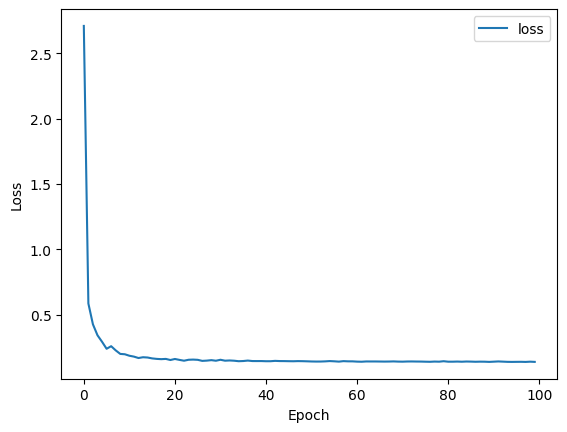

In [11]:
plt.plot(losses, label='loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

## Geometric Sequence Prediction

In [12]:
def generate_geometric_sequence_data(num_sequences, sequence_length, max_start=100, max_ratio=10):
    X_data = []
    Y_data = []

    for _ in range(num_sequences):
        start = np.random.randint(1, max_start)
        ratio = np.random.randint(2, max_ratio + 1)
        current_sequence_full = []

        for _ in range(sequence_length + 1):
            current_sequence_full.append(start)
            start *= ratio

        X_data.append(np.array(current_sequence_full[:-1]).reshape(sequence_length, 1))
        Y_data.append(np.array(current_sequence_full[1:]).reshape(sequence_length, 1))

    return np.array(X_data), np.array(Y_data)

In [13]:
class MinMaxScaler:
    def __init__(self):
        self.min_val = None
        self.max_val = None

    def fit(self, data):
        # Flatten data to find min/max across all samples/steps
        flattened_data = data.flatten()
        self.min_val = np.min(flattened_data)
        self.max_val = np.max(flattened_data)
        if self.max_val == self.min_val: # Handle constant data
            self.min_val -= 1
            self.max_val += 1

    def transform(self, data):
        return (data - self.min_val) / (self.max_val - self.min_val)

    def inverse_transform(self, scaled_data):
        return scaled_data * (self.max_val - self.min_val) + self.min_val

# Example: 1000 sequences, each 5 steps long
num_sequences = 1000
sequence_length = 5
X_train, Y_train = generate_geometric_sequence_data(num_sequences, sequence_length)

# Initialize scalers
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit scalers to the entire dataset (or just training set)
# It's crucial to fit on the full range of expected data values.
# For geometric sequences, numbers can become very large.
# You might need to generate a very large set of sequences to get
# a good estimate of the global min/max, or explicitly define min/max if known.
# For simplicity, fitting on the generated data:
combined_data = np.concatenate((X_train, Y_train), axis=1) # Combine for fitting
x_scaler.fit(combined_data)
y_scaler.fit(combined_data) # Often same scaler for X and Y in this task

# Transform data
X_train_scaled = x_scaler.transform(X_train)
Y_train_scaled = y_scaler.transform(Y_train)

In [14]:
rnn = RecurrentNeuralNetwork(sequence_length=sequence_length, hidden_size=32, lr=0.001)
losses = rnn.train(X_train_scaled, Y_train_scaled, epochs=100)

Epoch 1/100, Average Loss: 0.004413
Epoch 2/100, Average Loss: 0.004247
Epoch 3/100, Average Loss: 0.004160
Epoch 4/100, Average Loss: 0.004126
Epoch 5/100, Average Loss: 0.004128
Epoch 6/100, Average Loss: 0.004103
Epoch 7/100, Average Loss: 0.004063
Epoch 8/100, Average Loss: 0.004040
Epoch 9/100, Average Loss: 0.004013
Epoch 10/100, Average Loss: 0.003991
Epoch 11/100, Average Loss: 0.003982
Epoch 12/100, Average Loss: 0.003912
Epoch 13/100, Average Loss: 0.003927
Epoch 14/100, Average Loss: 0.003893
Epoch 15/100, Average Loss: 0.003862
Epoch 16/100, Average Loss: 0.003839
Epoch 17/100, Average Loss: 0.003840
Epoch 18/100, Average Loss: 0.003829
Epoch 19/100, Average Loss: 0.003799
Epoch 20/100, Average Loss: 0.003781
Epoch 21/100, Average Loss: 0.003764
Epoch 22/100, Average Loss: 0.003704
Epoch 23/100, Average Loss: 0.003744
Epoch 24/100, Average Loss: 0.003723
Epoch 25/100, Average Loss: 0.003702
Epoch 26/100, Average Loss: 0.003710
Epoch 27/100, Average Loss: 0.003693
Epoch 28/1

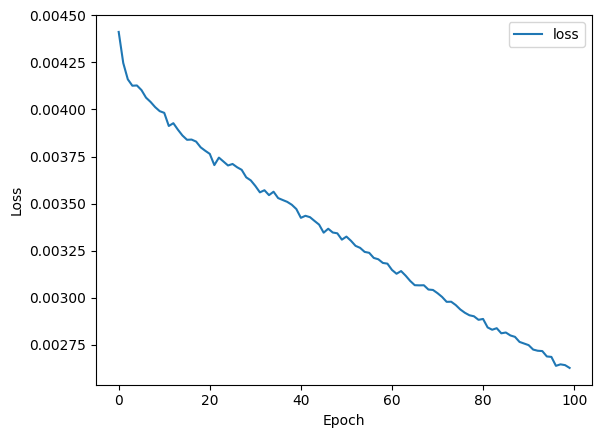

In [15]:
plt.plot(losses, label='loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
predictions = rnn.forward(X_train_scaled[0])
predictions, Y_train_scaled

(array([[0.00186249],
        [0.00526154],
        [0.00965921],
        [0.02203122],
        [0.11001782]]),
 array([[[2.11111132e-05],
         [6.35353600e-05],
         [1.90808100e-04],
         [5.72626320e-04],
         [1.71808098e-03]],
 
        [[1.68686886e-05],
         [3.38383873e-05],
         [6.77777846e-05],
         [1.35656579e-04],
         [2.71414169e-04]],
 
        [[4.73737422e-05],
         [2.37272751e-04],
         [1.18676780e-03],
         [5.93424302e-03],
         [2.96716192e-02]],
 
        ...,
 
        [[2.33333357e-05],
         [1.87373756e-04],
         [1.49969712e-03],
         [1.19982840e-02],
         [9.59869794e-02]],
 
        [[3.72727310e-05],
         [3.73636401e-04],
         [3.73727310e-03],
         [3.73736401e-02],
         [3.73737310e-01]],
 
        [[6.13131375e-05],
         [4.91212171e-04],
         [3.93040444e-03],
         [3.14439426e-02],
         [2.51552248e-01]]]))

In [17]:
X_test = np.array([[2], [6], [18], [54], [162]])
Y_test = np.array([[6], [18], [54], [162], [486]])

# Initialize scalers
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit scalers to the entire dataset (or just training set)
# It's crucial to fit on the full range of expected data values.
# For geometric sequences, numbers can become very large.
# You might need to generate a very large set of sequences to get
# a good estimate of the global min/max, or explicitly define min/max if known.
# For simplicity, fitting on the generated data:
combined_data = np.concatenate((X_test, Y_test), axis=1) # Combine for fitting
x_scaler.fit(combined_data)
y_scaler.fit(combined_data) # Often same scaler for X and Y in this task

# Transform data
X_train_scaled = x_scaler.transform(X_test)
Y_train_scaled = y_scaler.transform(Y_test)

predictions = rnn.forward(X_train_scaled)
predictions

array([[0.00185045],
       [0.01948212],
       [0.07531212],
       [0.24437199],
       [0.79541661]])